# Differential Dynamic Microscopy

This notebook implements the bacterial motility analysis routine **Differential Dynamic Microscopy (DDM)**. [Reference](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.018101)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
from corrLib import *
from scipy.optimize import curve_fit

## 1 Differential Intensity Correlation Function (DICF)

$$
\Delta I(\vec{r}, t) = I(\vec{r}, t) - \left<I\right>
$$

In [2]:
folder = r'C:\Users\liuzy\Documents\Data\DE\10262021\10\8-bit'
l = readdata(folder, 'tif')
img_list = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    img_list.append(img)
stack = np.stack(img_list)

In [3]:
I_mean = stack.mean(axis=0)

In [4]:
delta_I = stack - I_mean

$$
D(\vec{r}, \tau) = I(\vec{r}, t+\tau) - I(\vec{r}, t) = \Delta I(\vec{r}, \tau) - \Delta I(\vec{r}, 0)
$$

In [46]:
D1 = delta_I - np.roll(delta_I, 200, axis=0)
D1[0, :, :] = np.nan
D = np.nanmean(D1, axis=0)

In [55]:
def dynamic_diff_intensity(delta_I, tau=None):
    """Compute dynamic differential intensity of an image set
    Args:
    delta_I -- centered image intensity (0 mean)
    tau -- list of time difference, default to range(0, len(delta_I))
    
    Returns:
    D -- differential intensity with the first axis as different time difference
    tau -- time difference list
    """
    if tau == None:
        tau = range(0, len(delta_I))
    D_list = []
    for t in tau:
        D1 = delta_I - np.roll(delta_I, t, axis=0)
        D1[0, :, :] = np.nan
        D1_mean = np.nanmean(D1, axis=0)
        D_list.append(D1_mean)
    return np.stack(D_list, axis=0), tau

In [115]:
%%time
# tau = range(0, 500, 50)
D, tau = dynamic_diff_intensity(delta_I)

Wall time: 1h 2min 11s


In [116]:
D.shape

(500, 1022, 1024)

$$
F_D(\vec{q}, \tau)=\int D(\vec{r}, \tau) e^{i\vec{q}\cdot\vec{r}} d\vec{r}
$$

In [117]:
d = 0.11 # um, pixel size
F_D = np.fft.fft2(D) * d * d

$$
DICF = \left<|F_D(q,\tau)|^2\right>
$$

In [118]:
DICF2D = (F_D * F_D.conjugate()).real
DICF2D.shape

(500, 1022, 1024)

**Comments:** for every $q$, there is a DICF vs. $\tau$ function that can be fitted with the model. Here we test these fittings.

In [147]:
f1 = DICF2D[:, 200, 500]

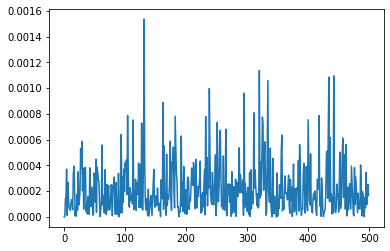

In [149]:
plt.plot(tau, f1)
# plt.plot(tau[1:], DICF_model([q2D[1, 0]*np.ones(len(tau)-1), tau[1:]], *[.1, 1, 0.00000001, 1, .2, 0]))

In [101]:
def DICF_model(x, v, alpha, sigma, D, A, B):
    """The DICF model from Wilson 2011
    Args:
    x -- [q, tau], the independent variables, k*M array
    v -- mean velocity, parameter
    alpha -- swimmer fraction, parameter, 0-1
    sigma -- velocity variance, parameter
    D -- diffusivity, parameter
    A -- ISF to DICF conversion coef, parameter
    B -- ISF to DICF conversion coef, parameter
    
    Returns:
    DICF -- model output
    """
    q = np.array(x[0])
    tau = np.array(x[1])
    Z = sigma ** 2 / v - 1
    theta = q * v * tau / (Z + 1)
    f = np.exp(-D*q**2*tau) * ((1 - alpha) + alpha * (Z + 1)/(Z*q*v*tau) * np.sin(Z*np.arctan(theta)) / (1 + theta**2)**(Z/2))
    DICF = A * (1 - f) + B
    return DICF

In [73]:
q2D, K = compute_wavenumber_field(DICF2D.shape[1:], d)

In [74]:
q2D.shape

(1022, 1024)

In [144]:
xdata = [q2D[1, 0]*np.ones(len(tau)-1), tau[1:]]
ydata = f1[1:]
popt, pcov = curve_fit(DICF_model, xdata, ydata, p0=[.5, 1, 0.1, 1, .2, 0])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

In [106]:
xdata

[array([0.05589028, 0.05589028, 0.05589028, 0.05589028, 0.05589028,
        0.05589028, 0.05589028, 0.05589028, 0.05589028]),
 range(50, 500, 50)]

In [127]:
popt

array([1., 1., 1., 1., 1., 1.])

In [66]:
def test_fit(x, a):
    return x[0] + x[1] + a

In [67]:
xdata = np.random.rand(2, 100)
ydata = np.random.rand(100)
popt, pcov = curve_fit(test_fit, xdata, ydata)

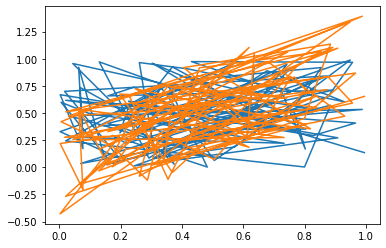

In [70]:
plt.plot(xdata[0], ydata)
plt.plot(xdata[0], test_fit(xdata, *popt))

In [40]:
q2D, K = compute_wavenumber_field(DICF2D.shape, d)

In [41]:
q1D, DICF1D = xy_bin(np.sort(q2D.flatten()), np.sort(DICF2D.flatten()))

C:\Users\liuzy\Documents\Github\Python\mylib\corrLib.py:678: RuntimeWarning: invalid value encountered in true_divide
  y = (np.histogram(xo, x, weights=yo)[0] /


[]

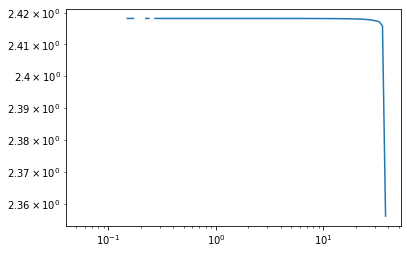

In [52]:
plt.plot(q1D, DICF.max()*1.1-DICF1D)
plt.loglog()

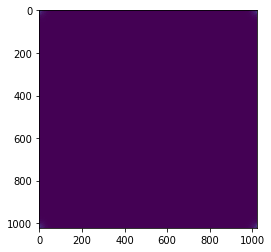

In [13]:
plt.imshow(DICF)

In [150]:
import pandas as pd

Alexandra bayles 2015
 

In [152]:
t = pd.read_csv(r'C:\Users\liuzy\Dropbox\Fluctuation Bacterial Droplets\Data_DE\03.csv', names=['x', 'y'])

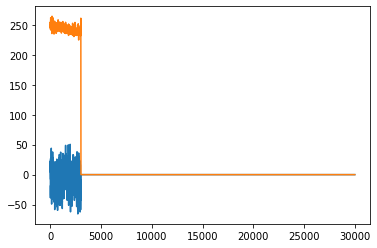

In [153]:
plt.plot(t.x)
plt.plot(t.y)